In [1]:
import pandas as pd
import numpy as np
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality
from cornac.data.text import BaseTokenizer
from cornac.models import MF, PMF, BPR
from cornac.metrics import MAE, RMSE, Precision, Recall, NDCG, AUC, MAP

from tqdm.notebook import tqdm
import random
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
posts = pd.read_pickle('data/posts_cleared.pkl')
posts.head()

,id,owner_id,date,text,likes,reposts,attachments,marked_as_ads,likes_id,clean_text
0,133540,-194512826,2022-08-10 10:03:00,несмотря на то что в детстве тебя гнобили и ун...,103,9,"[{'type': 'photo', 'photo': {'album_id': 27455...",0,"[410793517, 616126528, 560812373, 417061866, 4...",несмотря детстве гнобили унижали выросла увере...
1,133527,-194512826,2022-08-10 08:03:00,что-то не на рукожопском,359,55,"[{'type': 'photo', 'photo': {'album_id': 27455...",0,"[84261400, 608143054, 386867124, 467120708, 49...",рукожопском
2,133520,-194512826,2022-08-10 07:03:01,такую только на руки и сразу в загс,189,12,"[{'type': 'photo', 'photo': {'album_id': 28226...",0,"[539309607, 698827901, 612743278, 695332193, 5...",такую руки сразу загс
3,133517,-194512826,2022-08-10 06:03:00,едете с друзьями в санаторий с джакузи и кисло...,179,23,"[{'type': 'photo', 'photo': {'album_id': 27455...",0,"[348806758, 586377905, 371947448, 612743278, 4...",едете друзьями санаторий джакузи кислородными ...
4,133490,-194512826,2022-08-09 19:03:00,вайбы этого лета✨,186,16,"[{'type': 'photo', 'photo': {'album_id': 28226...",0,"[139471744, 612743278, 560812373, 325298462, 4...",вайбы лета


In [6]:
df_edges = pd.read_csv("edges_500.csv")
df_nodes = pd.read_csv("nodes_500.csv")

# Aggregating data for Graph

In [49]:
from collections import Counter

In [50]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [51]:
size = 1000
#size = posts.shape[0]

e = [('a', 'b', 0.3), ('b', 'c', 0.9), ('a', 'c', 0.5), ('c', 'd', 1.2)]

In [52]:
edges = []
for i in tqdm(range(size)):
    for j in range(i+1, size):
        name_1 = posts.iloc[i].id
        name_2 = posts.iloc[j].id
        weight = len(intersection(posts.iloc[i].likes_id, posts.iloc[j].likes_id))
        edges.append((name_1, name_2, 'Undirected', weight))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [53]:
df_edges = pd.DataFrame(edges, columns=['Source', 'Target', 'Type', 'Weight'])
df_edges.head(3)

,Source,Target,Type,Weight
0,133540,133527,Undirected,41
1,133540,133520,Undirected,22
2,133540,133517,Undirected,20


In [54]:
df_edges.shape

(499500, 4)

In [12]:
df_edges = df_edges.set_index('Source')

In [55]:
df_nodes = pd.concat([posts.id, posts.rename(columns={'id':'label'}).label, posts.rename(columns={'id':'Attribute1'}).Attribute1], axis=1)
df_nodes = df_nodes.set_index('id')

In [57]:
list_nodes = list(df_edges.index)

In [58]:
df_nodes = df_nodes.query('id in @list_nodes')

In [17]:
df_edges

,Target,Type,Weight
Source,,,
133540,133527,Undirected,41
133540,133520,Undirected,22
133540,133517,Undirected,20
133540,133490,Undirected,21
133540,133475,Undirected,3
...,...,...,...
128409,128391,Undirected,120
128409,128387,Undirected,373
128401,128391,Undirected,119


In [59]:
df_nodes.to_csv('nodes_1000.csv')
df_edges.to_csv('edges_1000.csv')

In [86]:
import pickle

In [87]:
with open('edges.pickle', 'wb') as handle:
    pickle.dump(edges, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [88]:
# Load data (deserialize)
with open('edges.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

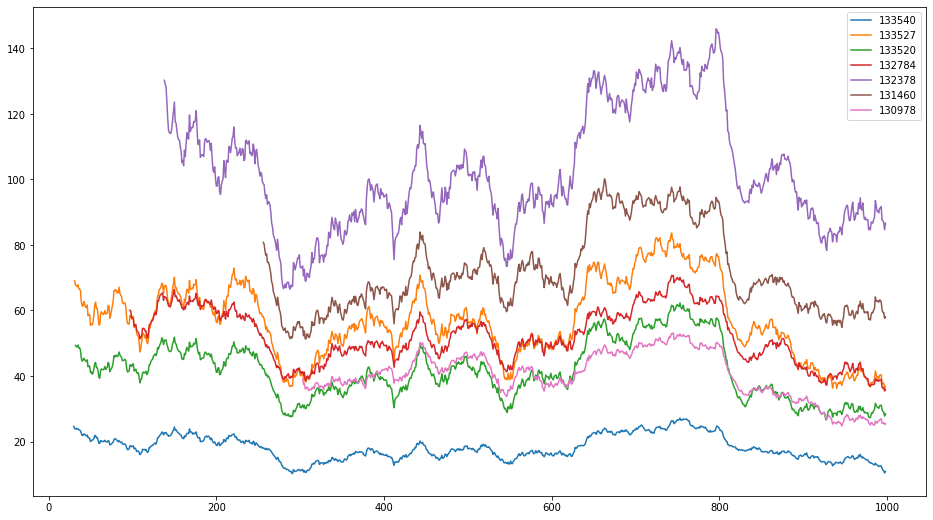

In [203]:
plt.figure(figsize=(16,9))
plt.plot(df_edges.query('Source == 133540').Weight.rolling(31).mean().values, label='133540')
plt.plot(np.linspace(1,998, 998), df_edges.query('Source == 133527').Weight.rolling(31).mean().values, label='133527')
plt.plot(np.linspace(2,998, 997), df_edges.query('Source == 133520').Weight.rolling(31).mean().values, label='133520')
plt.plot(np.linspace(67,998, 932), df_edges.query('Source == 132784').Weight.rolling(31).mean().values, label='132784')
plt.plot(np.linspace(108,998, 891), df_edges.query('Source == 132378').Weight.rolling(31).mean().values, label='132378')
plt.plot(np.linspace(226,998, 773), df_edges.query('Source == 131460').Weight.rolling(31).mean().values, label='131460')
plt.plot(np.linspace(273,998, 726), df_edges.query('Source == 130978').Weight.rolling(31).mean().values, label='130978')
plt.legend()
plt.show()

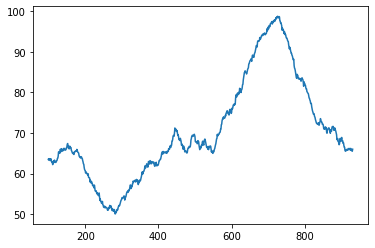

In [168]:
plt.plot(pd.Series(df_edges.query('Source == 132784').reset_index().Weight * np.linspace(1,1.7,932)).rolling(100).mean())

In [178]:
n = df_edges_clean.shape[0]

In [179]:
edges_list = [(df_edges_clean.iloc[i].Source, 
               df_edges_clean.iloc[i].Target, 
               df_edges_clean.iloc[i].Weight) 
               for i in tqdm(range(n))]

  0%|          | 0/372377 [00:00<?, ?it/s]

In [115]:
lst_edges = df_edges.Source.unique()
Weights = []
for i, source in tqdm(enumerate(lst_edges)):
    df = df_edges.query('Source == @source')
    weight = df.reset_index().Weight * np.linspace(1,2,1000-i-1)
    Weights.extend(weight)

0it [00:00, ?it/s]

{'whiskers': [<matplotlib.lines.Line2D at 0x296d9e4ec10>,
 'caps': [<matplotlib.lines.Line2D at 0x296d9e5e1f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x296d9e4e940>],
 'medians': [<matplotlib.lines.Line2D at 0x296d9e5e790>],
 'fliers': [],
 'means': []}

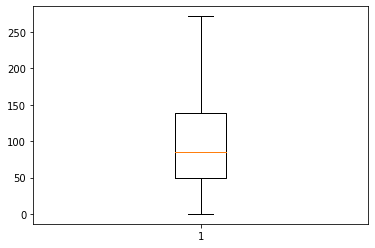

In [128]:
plt.boxplot(sorted(Weights), showfliers = False)

In [141]:
df_edges.Weight = [int(w) for w in Weights]

In [159]:
df_edges_clean = df_edges.drop(df_edges.index[np.where(df_edges.Weight < 50)])

In [198]:
df_edges_clean = df_edges_clean.set_index('Source')

In [199]:
df_edges_clean.to_csv('edges_clean_1000.csv')

In [171]:
nodes_lst = df_edges_clean.Source.unique()

In [176]:
df_nodes_clear = pd.DataFrame({'id':nodes_lst, 'Attribute1':nodes_lst})
df_nodes_clear.head()

,id,Attr1
0,133540,133540
1,133527,133527
2,133520,133520
3,133517,133517
4,133490,133490


# Creating a Graph

In [180]:
G = nx.Graph()
G.add_weighted_edges_from(edges_list)

In [181]:
comms = community_louvain.best_partition(G)

In [191]:
df_nodes_clear['Attr1'] = list(comms.values()[:-1:]

<AxesSubplot:>

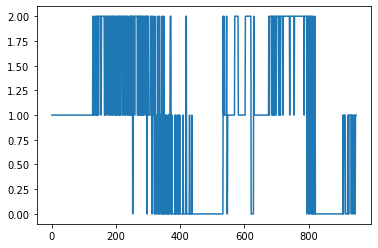

In [193]:
df_nodes_clear.Attr1.plot()

In [201]:
df_nodes_clear = df_nodes_clear.set_index('id')

In [202]:
df_nodes_clear.to_csv('nodes_clean_1000.csv')

In [183]:
ctr = Counter(comms.values())

In [184]:
ctr.most_common()

[(1, 365), (0, 308), (2, 277)]

In [4]:
feedback = []
for index, post in tqdm(posts.iterrows()):
    for user_id in post.likes_id:
        feedback.append((user_id, post.id, 1.0))

0it [00:00, ?it/s]

In [5]:
len(feedback)

1880732

In [112]:
ratio_split = RatioSplit(
    data=feedback,
    test_size=0.2,
    exclude_unknowns=True,
    item_text=item_text_modality,
    verbose=True,
    seed=123,
)

rating_threshold = 1.0
exclude_unknowns = True


C:\Anaconda\lib\site-packages\cornac\data\dataset.py:361: UserWarning: 3591 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 116159
Number of items = 4285
Number of ratings = 1500994
Max rating = 1.0
Min rating = 1.0
Global mean = 1.0


C:\Anaconda\lib\site-packages\cornac\data\dataset.py:361: UserWarning: 177 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Test data:
Number of users = 43181
Number of items = 4285
Number of ratings = 361468
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 116159
Total items = 4285


In [113]:
cdl = cornac.models.CDL(
    k=10,
    autoencoder_structure=[100],
    max_iter=30,
    lambda_u=0.1,
    lambda_v=1,
    lambda_w=0.1,
    lambda_n=1000,
    seed=123,
    verbose=True
)

In [114]:
models = [
    #MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02, use_bias=True, seed=123),
    #PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001, seed=123),
    #BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.02, num_threads=0, verbose=True),
    cdl
]

In [115]:
# define metrics to evaluate the models
metrics = [Precision(k=10), Recall(k=10), NDCG(k=10), MAP()]

пока что не работает текст, почему-то cornac считает, что в тексте есть NoneType'ы. Возможно, это из-за того, что не у всех айтемов есть описание

In [118]:
cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True, show_validation=True).run()


[CDL] Training started!


AttributeError: 'NoneType' object has no attribute 'batch_bow'

In [47]:
cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True, show_validation=True).run()


[BPR] Training started!


  0%|          | 0/400 [00:00<?, ?it/s]

Optimization finished!

[BPR] Evaluation started!


Ranking:   0%|          | 0/43181 [00:00<?, ?it/s]


TEST:
...
    |    MAP | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
--- + ------ + ------- + ------------ + --------- + --------- + --------
BPR | 0.0318 |  0.0363 |       0.0200 |    0.0486 |   56.6684 | 137.1479

